In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"""
# Balık Türü Sınıflandırma Projesi

## Veri Seti
- 9 farklı balık türü
- Her türden 1000 görüntü
- Toplam 9000 görüntü
- Görüntü boyutu: 64x64x3

## Model Mimarisi
- 3 Convolutional katman
- MaxPooling katmanları
- Dropout (0.5) düzenlemesi
- Dense katmanlar

## Model Performansı
- Eğitim doğruluğu: %96.04
- Doğrulama doğruluğu: %98.68
- Overfitting belirtisi yok
"""

In [2]:
# Gerekli kütüphaneleri import et
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import gc
from tensorflow.keras.utils import to_categorical

In [3]:
def create_dataframe(target_size=(128, 128)):
    base_path = "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"
    data = []
    
    # İşlenecek balık türleri
    valid_fish_types = [
        'Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet',
        'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream', 'Red Sea Bream'
    ]
    
    for fish_type in valid_fish_types:
        print(f"İşleniyor: {fish_type}")
        type_path = os.path.join(base_path, fish_type, fish_type)
        
        if os.path.exists(type_path):
            for img_name in os.listdir(type_path):
                if img_name.lower().endswith('.png'):
                    img_path = os.path.join(type_path, img_name)
                    try:
                        # Görüntüyü küçült ve işle
                        img = Image.open(img_path).resize(target_size)
                        img_array = np.array(img) / 255.0  # Normalize et
                        data.append({
                            'image': img_array,
                            'label': fish_type
                        })
                        
                        # Her 50 görüntüde bir durum raporu
                        if len(data) % 50 == 0:
                            print(f"İşlenen görüntü sayısı: {len(data)}")
                            gc.collect()  # Belleği temizle
                            
                    except Exception as e:
                        print(f"Hata - {img_path}: {str(e)}")
                        continue
    
    df = pd.DataFrame(data)
    print(f"\nToplam görüntü sayısı: {len(df)}")
    return df

# Belleği temizle
gc.collect()

# DataFrame'i oluştur
df = create_dataframe(target_size=(64, 64))  # Daha küçük boyut kullan

# DataFrame kontrolü
if df is not None and len(df) > 0:
    print("\nDataFrame başarıyla oluşturuldu!")
    print(f"Toplam görüntü sayısı: {len(df)}")
    print(f"Sütunlar: {df.columns.tolist()}")
    print("\nSınıf dağılımı:")
    print(df['label'].value_counts())

İşleniyor: Hourse Mackerel
İşlenen görüntü sayısı: 50
İşlenen görüntü sayısı: 100
İşlenen görüntü sayısı: 150
İşlenen görüntü sayısı: 200
İşlenen görüntü sayısı: 250
İşlenen görüntü sayısı: 300
İşlenen görüntü sayısı: 350
İşlenen görüntü sayısı: 400
İşlenen görüntü sayısı: 450
İşlenen görüntü sayısı: 500
İşlenen görüntü sayısı: 550
İşlenen görüntü sayısı: 600
İşlenen görüntü sayısı: 650
İşlenen görüntü sayısı: 700
İşlenen görüntü sayısı: 750
İşlenen görüntü sayısı: 800
İşlenen görüntü sayısı: 850
İşlenen görüntü sayısı: 900
İşlenen görüntü sayısı: 950
İşlenen görüntü sayısı: 1000
İşleniyor: Black Sea Sprat
İşlenen görüntü sayısı: 1050
İşlenen görüntü sayısı: 1100
İşlenen görüntü sayısı: 1150
İşlenen görüntü sayısı: 1200
İşlenen görüntü sayısı: 1250
İşlenen görüntü sayısı: 1300
İşlenen görüntü sayısı: 1350
İşlenen görüntü sayısı: 1400
İşlenen görüntü sayısı: 1450
İşlenen görüntü sayısı: 1500
İşlenen görüntü sayısı: 1550
İşlenen görüntü sayısı: 1600
İşlenen görüntü sayısı: 1650
İşlenen g

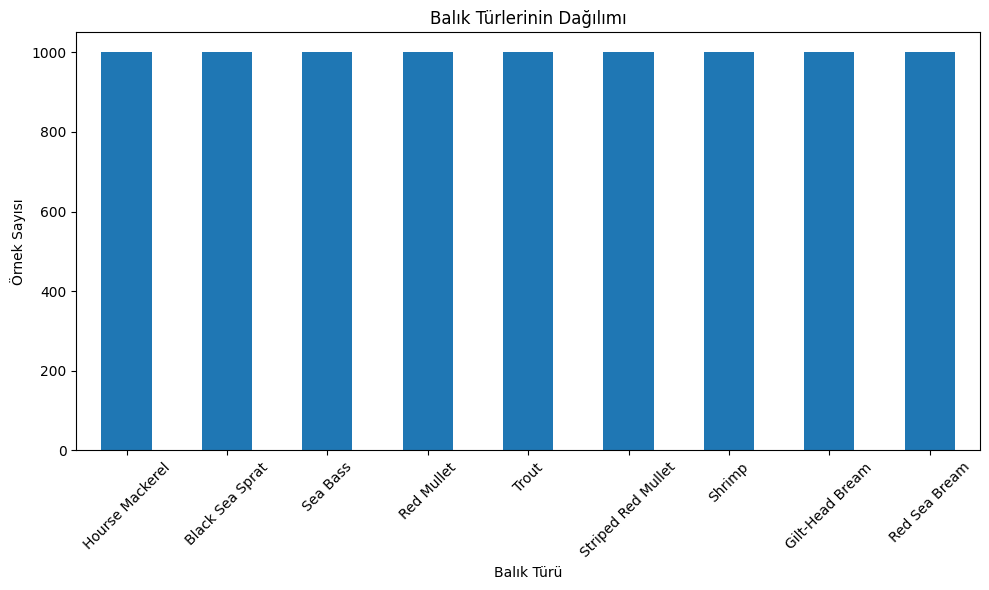

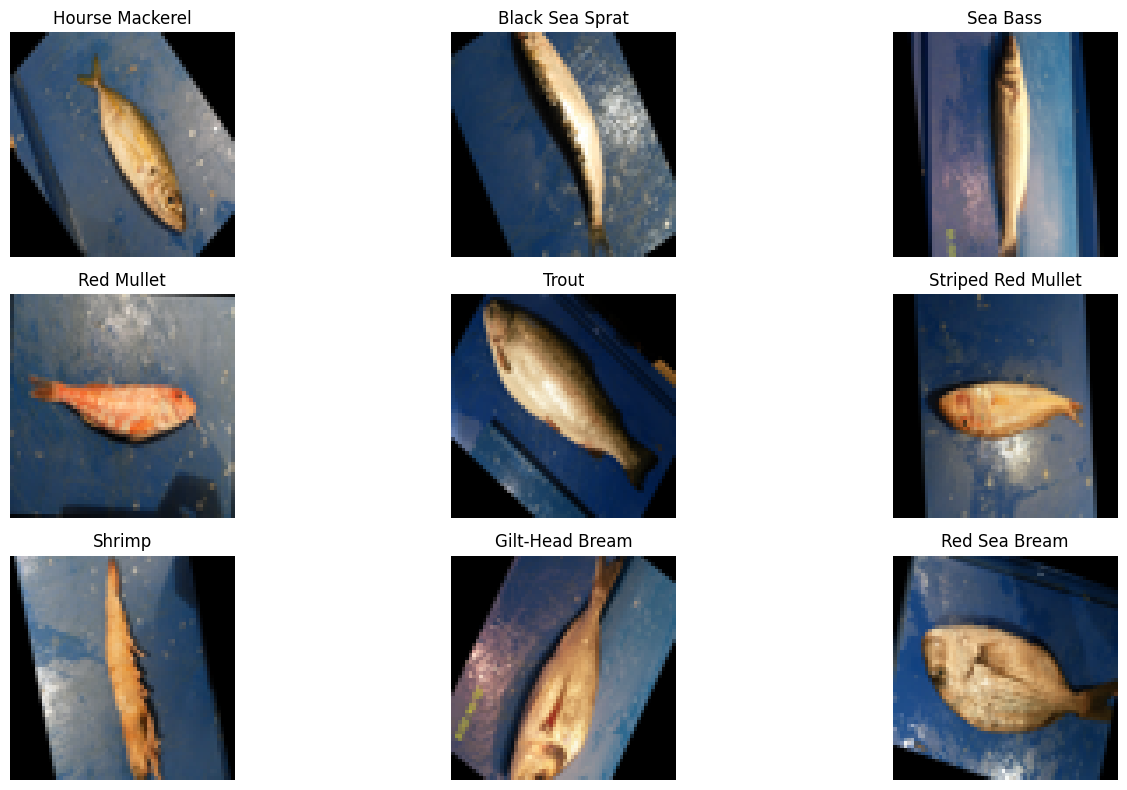

In [4]:
# Sınıf dağılımını görselleştir
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar')
plt.title('Balık Türlerinin Dağılımı')
plt.xlabel('Balık Türü')
plt.ylabel('Örnek Sayısı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Her sınıftan bir örnek görüntü göster
plt.figure(figsize=(15, 8))
for idx, label in enumerate(df['label'].unique()):
    plt.subplot(3, 3, idx+1)
    sample = df[df['label'] == label]['image'].iloc[0]
    plt.imshow(sample)
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# 1. Veriyi eğitim için hazırla
X = np.stack(df['image'].values)
print("Veri şekli:", X.shape)

# 2. Etiketleri sayısallaştır
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['label'])
print("Etiket sınıfları:", le.classes_)

# 3. Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4. One-hot encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("\nVeri boyutları:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

# 5. Model oluştur
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

# 6. Model derle
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 7. Model özeti
print("\nModel özeti:")
model.summary()

# 8. Model eğitimi
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Veri şekli: (9000, 64, 64, 3)
Etiket sınıfları: ['Black Sea Sprat' 'Gilt-Head Bream' 'Hourse Mackerel' 'Red Mullet'
 'Red Sea Bream' 'Sea Bass' 'Shrimp' 'Striped Red Mullet' 'Trout']

Veri boyutları:
X_train: (7200, 64, 64, 3)
X_test: (1800, 64, 64, 3)
y_train: (7200, 9)
y_test: (1800, 9)

Model özeti:


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,521 (1.34 MB)

 Trainable params: 352,521 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1729801451.567679     129 service.cc:145] XLA service 0x7b56c0008db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729801451.567738     129 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729801451.567743     129 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 34/180 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1337 - loss: 2.2011

I0000 00:00:1729801455.940473     129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2270 - loss: 2.0156 - val_accuracy: 0.5208 - val_loss: 1.2940
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5327 - loss: 1.2887 - val_accuracy: 0.7458 - val_loss: 0.7828
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6654 - loss: 0.9269 - val_accuracy: 0.8292 - val_loss: 0.4967
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7543 - loss: 0.6770 - val_accuracy: 0.8604 - val_loss: 0.4032
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8244 - loss: 0.4926 - val_accuracy: 0.9000 - val_loss: 0.2783
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8429 - loss: 0.4298 - val_accuracy: 0.8986 - val_loss: 0.2798
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8736 - loss: 0.3620 - val_accuracy: 0.9326 - val_loss: 0.2323
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8827 - loss: 0.3041 - val_accuracy: 0.9597 - val_

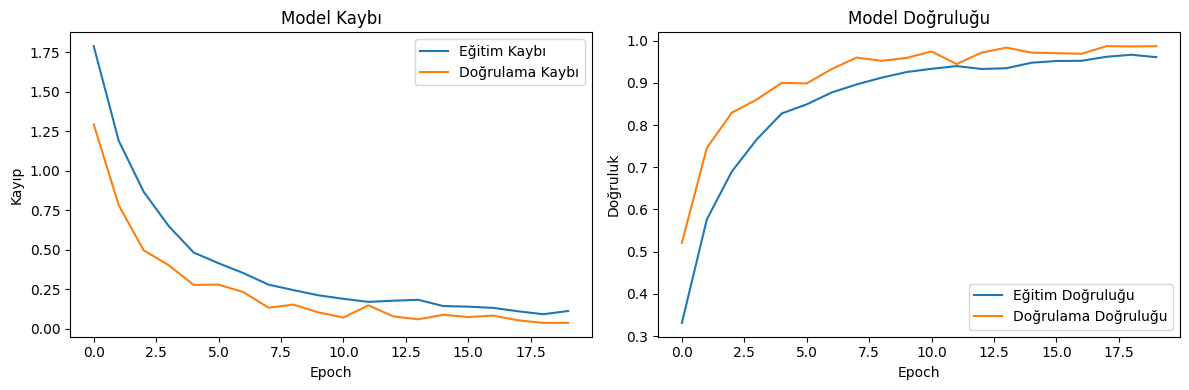

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


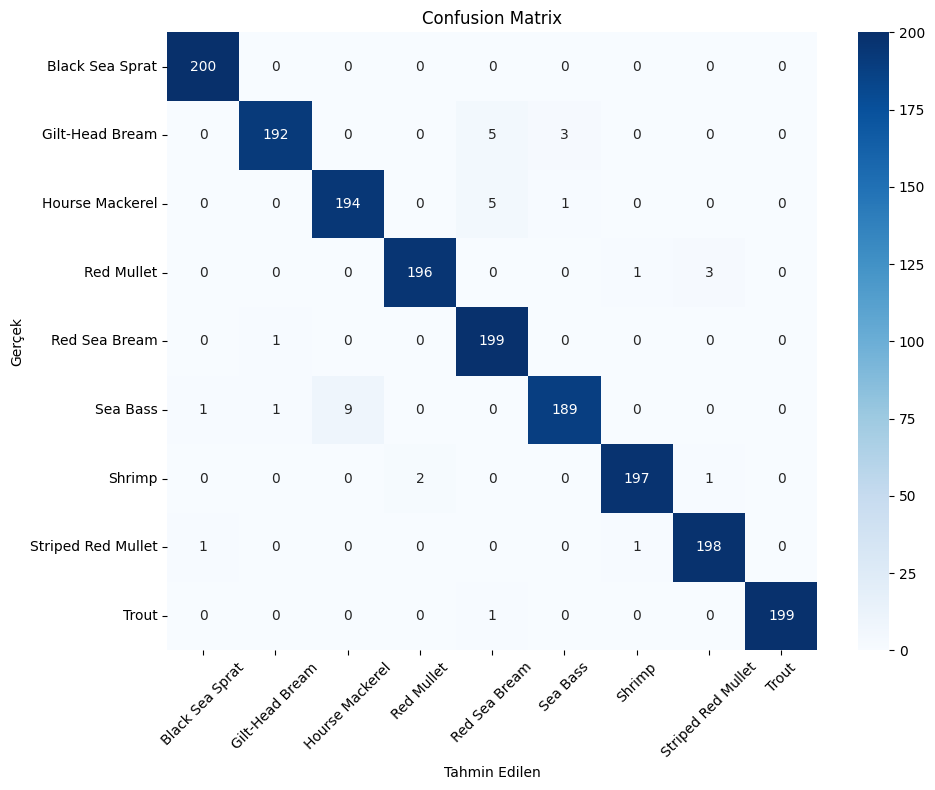


Sınıflandırma Raporu:
                    precision    recall  f1-score   support

   Black Sea Sprat       0.99      1.00      1.00       200
   Gilt-Head Bream       0.99      0.96      0.97       200
   Hourse Mackerel       0.96      0.97      0.96       200
        Red Mullet       0.99      0.98      0.98       200
     Red Sea Bream       0.95      0.99      0.97       200
          Sea Bass       0.98      0.94      0.96       200
            Shrimp       0.99      0.98      0.99       200
Striped Red Mullet       0.98      0.99      0.99       200
             Trout       1.00      0.99      1.00       200

          accuracy                           0.98      1800
         macro avg       0.98      0.98      0.98      1800
      weighted avg       0.98      0.98      0.98      1800



In [8]:
# Eğitim geçmişini görselleştir
plt.figure(figsize=(12, 4))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix ve Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Test seti üzerinde tahmin yap
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification Report
print("\nSınıflandırma Raporu:")
print(classification_report(y_test_classes, y_pred_classes,
                          target_names=le.classes_))

In [11]:
# Gerekli kütüphaneleri import et
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Model oluştur
inputs = Input(shape=X_train.shape[1:])
x = Conv2D(64, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(9, activation='softmax')(x)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

# Modeli derle
model_2.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model özeti
print("Model özeti:")
model_2.summary()

# Modeli eğit
history_2 = model_2.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Model özeti:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,405,449 (5.36 MB)

 Trainable params: 1,405,449 (5.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.3071 - loss: 1.8369 - val_accuracy: 0.7451 - val_loss: 0.7665
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7183 - loss: 0.7766 - val_accuracy: 0.8319 - val_loss: 0.4761
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8565 - loss: 0.4118 - val_accuracy: 0.9222 - val_loss: 0.2425
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8936 - loss: 0.2850 - val_accuracy: 0.9375 - val_loss: 0.1714
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9411 - loss: 0.1752 - val_accuracy: 0.9042 - val_loss: 0.2410
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9593 - loss: 0.1336 - val_accuracy: 0.9083 - val_loss: 0.2279
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9565 - loss: 0.1302 - val_accuracy: 0.9736 - val_loss: 0.0633
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9734 - loss: 0.0771 - val_accuracy: 0

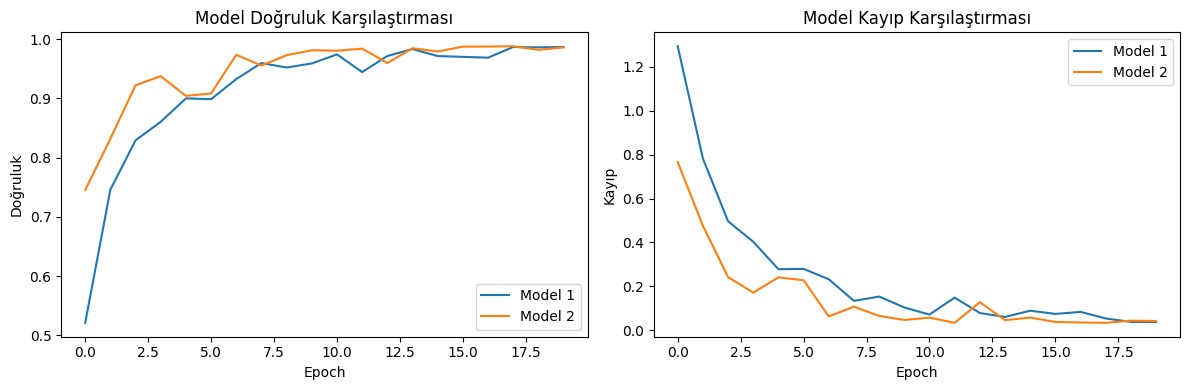

In [12]:
# İki modelin performans karşılaştırması
plt.figure(figsize=(12, 4))

# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], label='Model 1')
plt.plot(history_2.history['val_accuracy'], label='Model 2')
plt.title('Model Doğruluk Karşılaştırması')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Model 1')
plt.plot(history_2.history['val_loss'], label='Model 2')
plt.title('Model Kayıp Karşılaştırması')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()

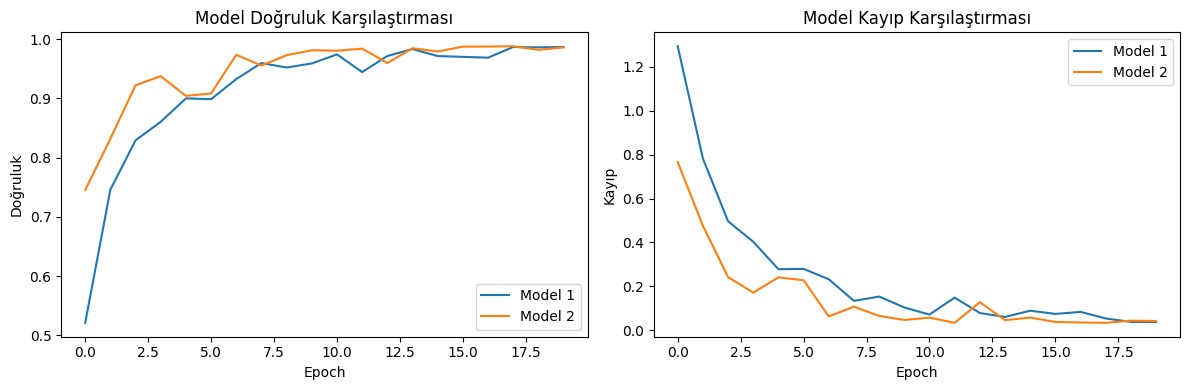

In [13]:
# Grafiklerin kaydedilmesi
plt.figure(figsize=(12, 4))

# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], label='Model 1')
plt.plot(history_2.history['val_accuracy'], label='Model 2')
plt.title('Model Doğruluk Karşılaştırması')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.savefig('model_accuracy.png')  # Kaydet

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Model 1')
plt.plot(history_2.history['val_loss'], label='Model 2')
plt.title('Model Kayıp Karşılaştırması')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.savefig('model_loss.png')  # Kaydet

plt.tight_layout()